In [2]:
pip install networkx gensim


Following:

https://arxiv.org/pdf/1607.00653.pdf

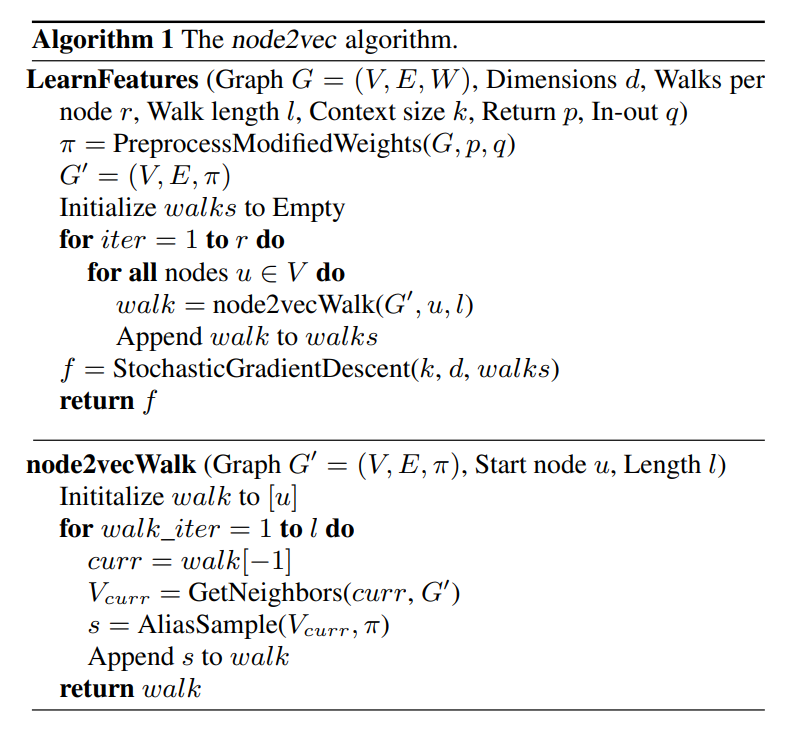

The `node2vec` algorithm is a method to generate node embeddings from a given graph. The general idea of the algorithm is to perform random walks on the graph starting from each node. The transition probabilities for these random walks are modified to capture the structural and homophily biases in the graph. These random walks are then used as input sequences to the Skip-gram model to learn embeddings for each node.

Let's break down the pseudocode:

### LearnFeatures
This is the main function of the `node2vec` algorithm.

1. **Input Parameters**:
    - `G = (V, E, W)`: The input graph where \(V\) is the set of nodes, \(E\) is the set of edges, and \(W\) is the set of edge weights.
    - `d`: Dimension of the embeddings.
    - `r`: Number of random walks per node.
    - `l`: Length of each random walk.
    - `k`: Context size for the Skip-gram model.
    - `p`: Return parameter. It controls the likelihood of immediately revisiting a node in the walk.
    - `q`: In-out parameter. It allows the search to differentiate between inward and outward nodes.

2. **Steps**:
    - Preprocess the graph to compute modified transition probabilities using the `PreprocessModifiedWeights` function.
    - Reinitialize the graph with the modified transition probabilities.
    - Perform \(r\) random walks starting from each node in the graph. The random walk for each node is generated using the `node2vecWalk` function.
    - Use the sequences obtained from the random walks as input to the Skip-gram model and learn the embeddings using Stochastic Gradient Descent (SGD).

### node2vecWalk
This function simulates a random walk on the graph.

1. **Input Parameters**:
    - `G0 = (V, E, π)`: The graph with the modified transition probabilities.
    - `u`: The starting node for the random walk.
    - `l`: Length of the random walk.

2. **Steps**:
    - Initialize the walk with the starting node.
    - For each step in the walk:
        - Get the current node.
        - Get the neighbors of the current node.
        - Sample a neighbor based on the transition probabilities using the `AliasSample` method.
        - Add the sampled node to the walk.

The resulting walk is a sequence of nodes from the graph.

---


In [12]:
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import random

In [13]:
class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1, workers=1):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.workers = workers
        self.walks = []
        self.model = None

    def preprocess_transition_probs(self):
        # Placeholder: In actual implementation, you would modify the edge weights based on p and q
        # Here, we'll assume equal transition probabilities for simplicity
        for node in self.graph.nodes():
            neighbors = list(self.graph.neighbors(node))
            normalized_probs = {neighbor: 1/len(neighbors) for neighbor in neighbors}
            nx.set_node_attributes(self.graph, {node: normalized_probs}, 'transition_probs')

    def node2vec_walk(self, start_node):
        walk = [start_node]
        while len(walk) < self.walk_length:
            current = walk[-1]
            neighbors = list(self.graph.neighbors(current))
            if len(neighbors) == 0:
                break  # We've reached a node with no neighbors

            probs = [self.graph.nodes[current]['transition_probs'].get(neighbor, 0) for neighbor in neighbors]
            next_node = np.random.choice(neighbors, p=probs)
            walk.append(next_node)
        return walk

    def simulate_walks(self):
        walks = []
        nodes = list(self.graph.nodes())
        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walk = self.node2vec_walk(node)
                walks.append(walk)
        self.walks = walks

    def learn_embeddings(self):
        self.model = Word2Vec(sentences=self.walks, vector_size=self.dimensions, window=10, min_count=0, sg=1, workers=self.workers, epochs=1)

    def train(self):
        self.preprocess_transition_probs()
        self.simulate_walks()
        self.learn_embeddings()

    # Pair representation generation using different operators
    def get_pair_representation(self, u, v, operator='average'):
        u_emb = self.model.wv[u]
        v_emb = self.model.wv[v]

        if operator == 'average':
            return (u_emb + v_emb) / 2
        elif operator == 'hadamard':
            return u_emb * v_emb
        elif operator == 'subtract':
            return u_emb - v_emb
        elif operator == 'concat':
            return np.concatenate((u_emb, v_emb), axis=0)
        else:
            raise ValueError(f"Unknown operator {operator}")



In [15]:
# Load the Karate Club graph
karate_graph = nx.karate_club_graph()

# Train node2vec on the Karate Club graph
node2vec_karate = Node2Vec(karate_graph, dimensions=3)  # Using 3 dimensions for simplicity
node2vec_karate.train()

# Get the embeddings in 3D
embeddings_3d = {node: node2vec_karate.model.wv[node] for node in karate_graph.nodes()}

# Extract 2D embeddings from the 3D embeddings
embeddings_2d = {node: embedding[:2] for node, embedding in embeddings_3d.items()}

embeddings_2d, embeddings_3d


({0: array([ 0.41660026, -1.0231893 ], dtype=float32),
  1: array([ 0.31168088, -0.3162194 ], dtype=float32),
  2: array([ 0.3237958 , -0.12217928], dtype=float32),
  3: array([ 0.35778257, -0.41903192], dtype=float32),
  4: array([-0.39581484, -1.0131513 ], dtype=float32),
  5: array([-0.42784873, -1.1924232 ], dtype=float32),
  6: array([-0.2619041, -1.1904143], dtype=float32),
  7: array([ 0.3896165, -0.6506654], dtype=float32),
  8: array([ 0.6401012 , -0.39529234], dtype=float32),
  9: array([ 0.39382595, -0.0917096 ], dtype=float32),
  10: array([-0.15366097, -1.049106  ], dtype=float32),
  11: array([ 0.17285421, -0.88559353], dtype=float32),
  12: array([ 0.25788146, -0.59734464], dtype=float32),
  13: array([ 0.41288796, -0.5343975 ], dtype=float32),
  14: array([ 0.7544411 , -0.07249884], dtype=float32),
  15: array([ 0.5470918 , -0.05667048], dtype=float32),
  16: array([-0.4477577, -1.3978643], dtype=float32),
  17: array([ 0.17543459, -0.43814364], dtype=float32),
  18: ar

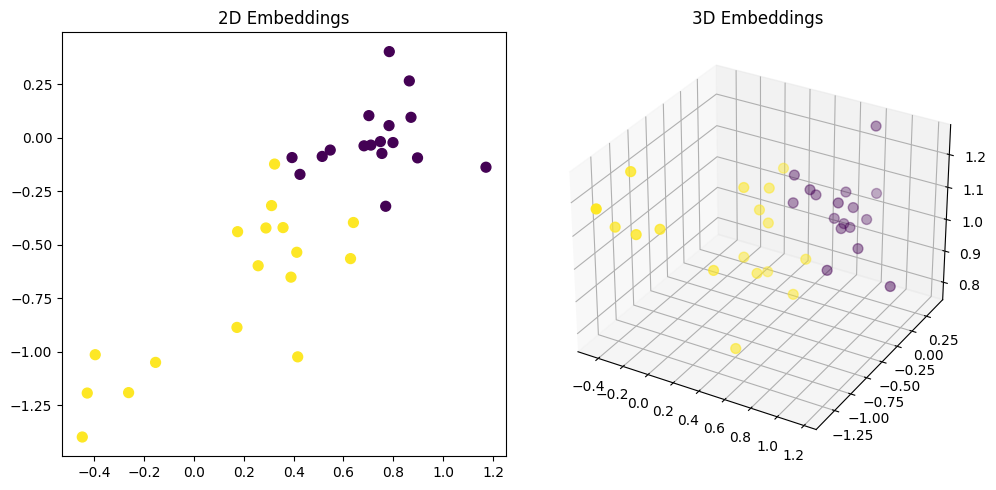

In [17]:
import matplotlib.pyplot as plt

# Extract the club classes for coloring the nodes
clubs = nx.get_node_attributes(karate_graph, 'club')
colors = [1 if club == "Mr. Hi" else 0 for club in clubs.values()]

# Plot 2D embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter([embeddings_2d[node][0] for node in karate_graph.nodes()],
            [embeddings_2d[node][1] for node in karate_graph.nodes()],
            c=colors, cmap='viridis', s=50)
plt.title('2D Embeddings')

# Plot 3D embeddings
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter([embeddings_3d[node][0] for node in karate_graph.nodes()],
           [embeddings_3d[node][1] for node in karate_graph.nodes()],
           [embeddings_3d[node][2] for node in karate_graph.nodes()],
           c=colors, cmap='viridis', s=50)
ax.set_title('3D Embeddings')

plt.tight_layout()
plt.show()
